## 12.3 神经风格迁移 `neural style transfer`
---
核心思想：定义一个损失函数来指定想实现的目标，然后将损失最小化。

### 12.3.1 内容损失

### 12.3.2 风格损失

### 12.3.3 用`Keras`实现神经风格迁移

In [16]:
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#### [C] 12.16 获取风格图像和内容图像

In [2]:
base_image_path            = keras.utils.get_file("sf.jpg"          , origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 2s 2us/step


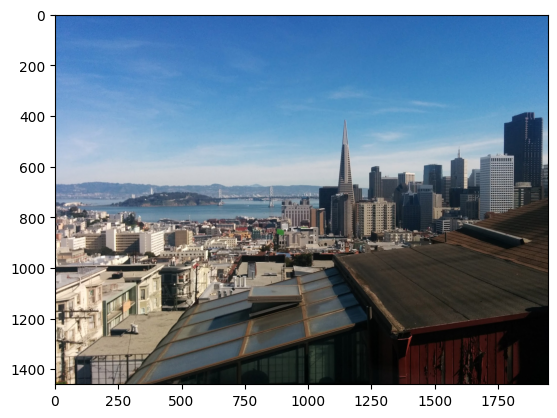

In [7]:
plt.imshow(keras.utils.load_img(base_image_path))

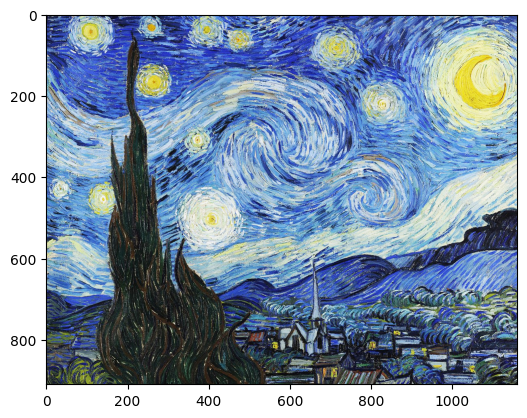

In [8]:
plt.clf()
plt.imshow(keras.utils.load_img(style_reference_image_path))

#### [C] 12.17 辅助函数
---
通过`VGG19`网络的图像进行加载、预处理和后处理


In [10]:
def preprocess_image(image_path):
    
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    
    return img

def deprocess_image(img):
    
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img

#### [C] 12.18 使用预训练`VGG19`模型来创建一个特征提取器

In [11]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict      = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 23s 0us/step


#### [C] 12.19 内容损失函数

In [18]:
def content_loss(base_img, combination_img):
    
    return tf.reduce_sum(tf.square(combination_img - base_img))

#### [C] 12.20 风格损失函数

In [19]:
def gram_matrix(x):
    
    x        = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram     = tf.matmul(features, tf.transpose(features))
    
    return gram

def style_loss(style_img, combination_img):
    
    S        = gram_matrix(style_img)
    C        = gram_matrix(combination_img)
    channels = 3
    size     = img_height * img_width
    
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

#### [C] 12.21 总变差损失函数

In [20]:
def total_variation_loss(x):
    
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    
    return tf.reduce_sum(tf.pow(a + b, 1.25))

#### [C] 12.22 定义需要最小化的最终损失函数

In [21]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name     = "block5_conv2"  # 用于内容损失的层
total_variation_weight = 1e-6            # 总变差损失的贡献权重
style_weight           = 1e-6            # 风格损失的贡献权重
content_weight         = 2.5e-8          # 内容损失的贡献权重

def compute_loss(combination_image, base_image, style_reference_image):
    
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    features             = feature_extractor(input_tensor)
    loss                 = tf.zeros(shape=())  # 损失初始值为0

    # 添加内容损失
    layer_features       = features[content_layer_name]
    base_image_features  = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss                 = loss + content_weight * content_loss(base_image_features, combination_features)

    # 添加风格损失
    for layer_name in style_layer_names:
    
        layer_features           = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features     = layer_features[2, :, :, :]
        style_loss_value         = style_loss(style_reference_features, combination_features)
        loss                    += (style_weight / len(style_layer_names)) * style_loss_value

    # 添加总变差损失
    loss += total_variation_weight * total_variation_loss(combination_image)
    
    return loss

#### [C] 12.23 设置梯度下降过程

In [22]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image            = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image     = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    
    optimizer.apply_gradients([(grads, combination_image)])
    
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8137.06
Iteration 200: loss=6652.31
